In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Load the enhanced dataset with new features
logs_df = pd.read_csv("/Users/davidstroud/cloud_logs/anomaly_detection/engineered_logs_with_advanced_features_combined.csv")

# Select features and target
features = ['hour', 'unusual_hour', 'geo_anomaly', 'action_count', 'failed_actions_count', 
            'time_of_day', 'day_of_week', 'is_weekend', 'action_frequency', 'resource_frequency', 
            'action_resource_combo', 'is_high_response_code', 'consecutive_failed_actions', 
            'mean_response_code', 'mean_hour', 'user_entropy', 'usage_rate', 'action_diversity', 
            'response_code_divergence', 'consecutive_high_response', 'time_since_last_action', 
            'session', 'avg_session_length', 'region_resource_interaction', 'cross_region_access']

target = 'failed_action'
 
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(logs_df[features], logs_df[target], test_size=0.2, random_state=42)

# Numerical features to scale
numeric_features = ['hour', 'action_count', 'failed_actions_count', 'is_high_response_code', 
                    'consecutive_failed_actions', 'mean_response_code', 'mean_hour', 
                    'user_entropy', 'usage_rate', 'action_diversity', 'response_code_divergence', 
                    'consecutive_high_response', 'time_since_last_action', 'session', 'avg_session_length', 
                    'cross_region_access']

# Categorical features to one-hot encode
categorical_features = ['time_of_day', 'day_of_week', 'action_resource_combo', 'region_resource_interaction']

# Create a pipeline for numerical features including imputation and scaling
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values with mean
    ('scaler', StandardScaler())
])

# Create a pipeline for categorical features including imputation and one-hot encoding
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Impute missing values with most frequent value
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Create a column transformer with pipelines for numeric and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Fit and transform the training data, transform the test data
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Check for any remaining NaN values
print(f"Number of NaNs in training data after preprocessing: {np.isnan(X_train_processed).sum()}")
print(f"Number of NaNs in test data after preprocessing: {np.isnan(X_test_processed).sum()}")


Number of NaNs in training data after preprocessing: 0
Number of NaNs in test data after preprocessing: 0


In [14]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1],
    'gamma': [0, 0.1, 0.2]
}

# Initialize the XGBoost classifier
xgb_clf = xgb.XGBClassifier(random_state=42, eval_metric='logloss')

# Set up GridSearchCV with 3-fold cross-validation
grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, 
                           scoring='roc_auc', cv=3, verbose=2, n_jobs=-1)

# Fit GridSearchCV to find the best parameters
grid_search.fit(X_train_processed, y_train)

# Display the best parameters found by GridSearchCV
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best ROC AUC score: {grid_search.best_score_}")

# Train the XGBoost classifier with the best parameters
best_xgb_clf = grid_search.best_estimator_

# Predict on the test set
y_pred_xgb_best = best_xgb_clf.predict(X_test_processed)

# Evaluate the model
print("\nOptimized XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb_best))
print("Optimized XGBoost Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb_best))
print("Optimized XGBoost ROC AUC Score:", roc_auc_score(y_test, y_pred_xgb_best))


Fitting 3 folds for each of 972 candidates, totalling 2916 fits
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=50, subsample=1; total time=   0.4s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=50, subsample=1; total time=   0.4s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=50, subsample=1; total time=   0.4s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=50, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=50, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=50, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, min_c


Optimized XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.88      0.88     15238
           1       0.62      0.64      0.63      4762

    accuracy                           0.82     20000
   macro avg       0.75      0.76      0.76     20000
weighted avg       0.82      0.82      0.82     20000

Optimized XGBoost Confusion Matrix:
[[13378  1860]
 [ 1702  3060]]
Optimized XGBoost ROC AUC Score: 0.7602619426808209


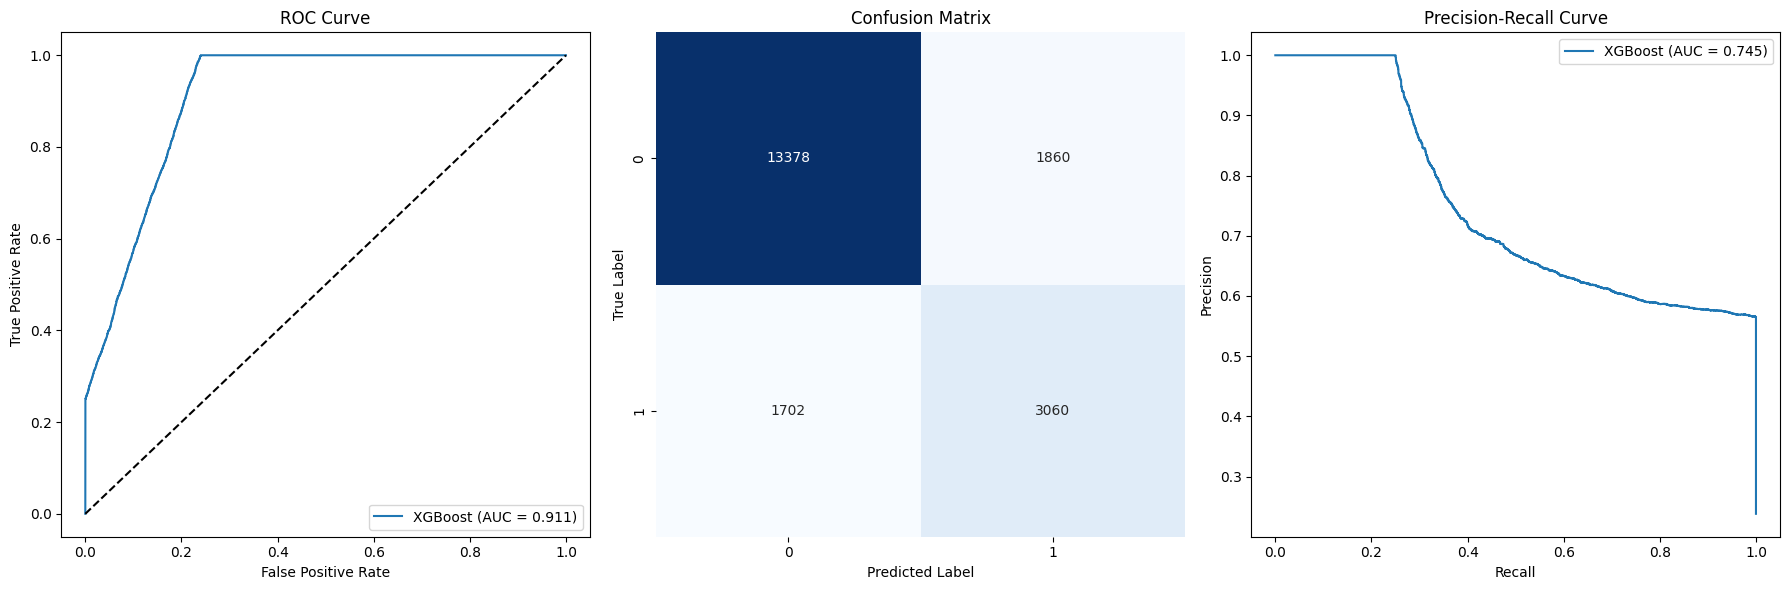

In [20]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluate the model
print("\nOptimized XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb_best))
print("Optimized XGBoost Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb_best))
print("Optimized XGBoost ROC AUC Score:", roc_auc_score(y_test, y_pred_xgb_best))

# Plot ROC Curve
y_proba_xgb_best = best_xgb_clf.predict_proba(X_test_processed)[:, 1]  # Get probability scores for positive class
fpr, tpr, thresholds = roc_curve(y_test, y_proba_xgb_best)
roc_auc = roc_auc_score(y_test, y_proba_xgb_best)

plt.figure(figsize=(18, 6))

# Subplot 1: ROC Curve
plt.subplot(1, 3, 1)
plt.plot(fpr, tpr, label='XGBoost (AUC = {:.3f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')

# Subplot 2: Confusion Matrix
plt.subplot(1, 3, 2)
cm = confusion_matrix(y_test, y_pred_xgb_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

# Subplot 3: Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_proba_xgb_best)
pr_auc = auc(recall, precision)
plt.subplot(1, 3, 3)
plt.plot(recall, precision, label='XGBoost (AUC = {:.3f})'.format(pr_auc))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')

plt.tight_layout()
plt.show()

